# Reproduces Sec. 4.2 in main paper and Sec. 4 in Supplement.

In [7]:
# !pip install scikit-image==0.20.0 scikit-video==1.1.11 opencv-python==4.7.0.72 cmapy==0.6.6 ConfigArgParse==1.5.3 -q
# !pip uninstall scipy -y; pip install scipy

Found existing installation: scipy 1.9.1
Uninstalling scipy-1.9.1:
  Successfully uninstalled scipy-1.9.1
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.20.0 requires scipy<1.9.2,>=1.8; python_version <= "3.9", but you have scipy 1.10.1 which is incompatible.


In [1]:
# Enable import from parent package
import sys
import os
sys.path.append('siren')

In [8]:
import dataio, meta_modules, utils, training, loss_functions, modules

from torch.utils.data import DataLoader
import configargparse

In [11]:
from dataclasses import dataclass
import os

@dataclass
class Config:
    logging_root: str = './logs' # root for logging
    experiment_name: str = 'default_experiment' # Name of subdirectory in logging_root where summaries and checkpoints will be saved.
    batch_size: int = 1400
    lr: float = 1e-4 # learning rate. default=5e-5
    num_epochs: int = 10000 # Number of epochs to train for.
    epochs_til_ckpt: int = 1 # Time interval in seconds until checkpoint is saved.
    steps_til_summary: int = 100 # Time interval in seconds until tensorboard summary is saved.
    model_type: str = 'sine' # Options are "sine" (all sine activations) and "mixed" (first layer sine, other layers tanh)
    point_cloud_path: str = os.path.expanduser('~/data/point_cloud.xyz')
    checkpoint_path: str = None
    device: str = 'cuda:0'

# Initialize the configuration object
opt = Config(
    experiment_name='siren_sdf_baseline',  # Replace this with your experiment name
    point_cloud_path='/app/notebooks/siren_sdf/data/interior_room.xyz',  # Replace this with your point cloud path
    # Add any other customizations here
)

# Now you can access the values in the config object like this:
print(opt.logging_root)

./logs


In [12]:
sdf_dataset = dataio.PointCloud(opt.point_cloud_path, on_surface_points=opt.batch_size)
dataloader = DataLoader(sdf_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

# Define the model.
if opt.model_type == 'nerf':
    model = modules.SingleBVPNet(type='relu', mode='nerf', in_features=3)
else:
    model = modules.SingleBVPNet(type=opt.model_type, in_features=3)
model = model.to(opt.device)

Loading point cloud
Finished loading point cloud
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=3, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)


In [13]:
# Define the loss
loss_fn = loss_functions.sdf
summary_fn = utils.write_sdf_summary

root_path = os.path.join(opt.logging_root, opt.experiment_name)

  0%|          | 0/73210000 [00:00<?, ?it/s]

Epoch 0, Total loss 135.598389, iteration time 1.707341
Epoch 0, Total loss 42.274826, iteration time 0.949137
Epoch 0, Total loss 34.821156, iteration time 1.119152
Epoch 0, Total loss 36.465881, iteration time 0.923702
Epoch 0, Total loss 33.514988, iteration time 0.944230
Epoch 0, Total loss 32.655991, iteration time 0.912927
Epoch 0, Total loss 29.753780, iteration time 0.937042
Epoch 0, Total loss 29.938541, iteration time 0.917580
Epoch 0, Total loss 28.547352, iteration time 0.950050
Epoch 0, Total loss 28.036057, iteration time 1.165006
Epoch 0, Total loss 30.734983, iteration time 0.933760
Epoch 0, Total loss 29.303410, iteration time 0.934018
Epoch 0, Total loss 28.038788, iteration time 0.927094
Epoch 0, Total loss 25.404247, iteration time 0.936259
Epoch 0, Total loss 26.924944, iteration time 0.929770
Epoch 0, Total loss 31.461979, iteration time 0.928057
Epoch 0, Total loss 29.103146, iteration time 0.926388
Epoch 0, Total loss 28.414515, iteration time 1.239055
Epoch 0, 

KeyboardInterrupt: 

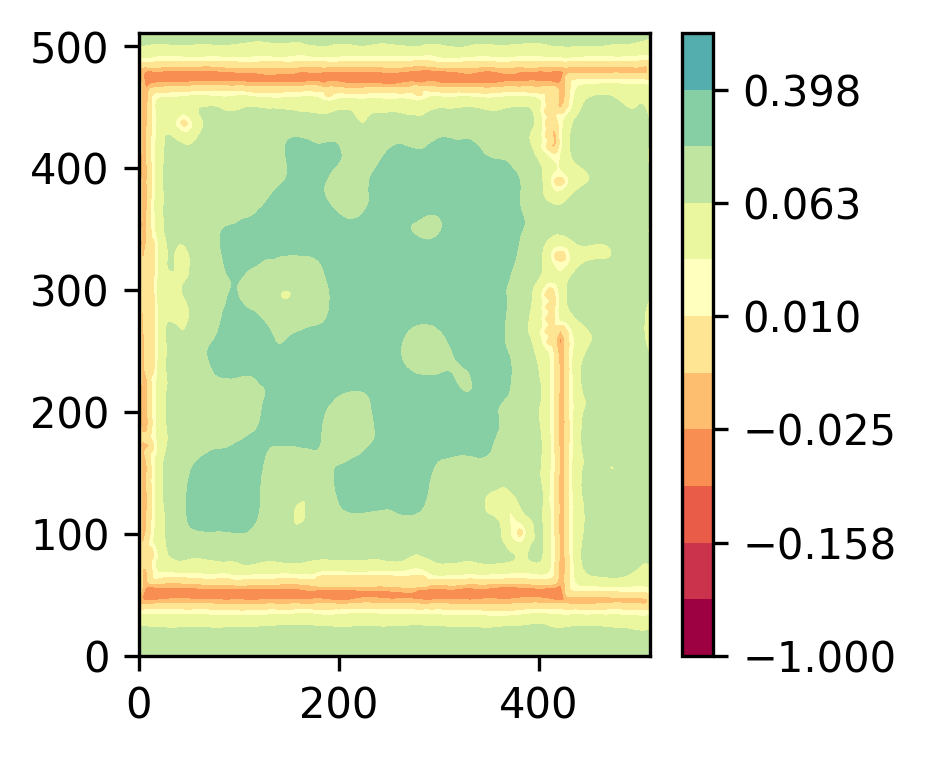

In [14]:
training.train(model=model, train_dataloader=dataloader, epochs=opt.num_epochs, lr=opt.lr,
               steps_til_summary=opt.steps_til_summary, epochs_til_checkpoint=opt.epochs_til_ckpt,
               model_dir=root_path, loss_fn=loss_fn, summary_fn=summary_fn, double_precision=False,
               clip_grad=True)